[[Tutorial] Time Series forecasting with XGBoost](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Libaries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/DSAI Project/Data/Tetuan City power consumption.csv", parse_dates=['DateTime'], index_col=['DateTime'])
data

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [ ]:
data.drop(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows'], axis=1, inplace=True)
data

,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,
2017-01-01 00:00:00,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,27335.69620,17872.34043,18442.40964
...,...,...,...
2017-12-30 23:10:00,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,29590.87452,25277.69254,13806.48259


In [ ]:
data['Total Power Consumption'] = data['Zone 1 Power Consumption'] + data['Zone 2  Power Consumption'] + data['Zone 3  Power Consumption']
data

,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Total Power Consumption
DateTime,,,,
2017-01-01 00:00:00,34055.69620,16128.87538,20240.96386,70425.53544
2017-01-01 00:10:00,29814.68354,19375.07599,20131.08434,69320.84387
2017-01-01 00:20:00,29128.10127,19006.68693,19668.43373,67803.22193
2017-01-01 00:30:00,28228.86076,18361.09422,18899.27711,65489.23209
2017-01-01 00:40:00,27335.69620,17872.34043,18442.40964,63650.44627
...,...,...,...,...
2017-12-30 23:10:00,31160.45627,26857.31820,14780.31212,72798.08659
2017-12-30 23:20:00,30430.41825,26124.57809,14428.81152,70983.80786
2017-12-30 23:30:00,29590.87452,25277.69254,13806.48259,68675.04965


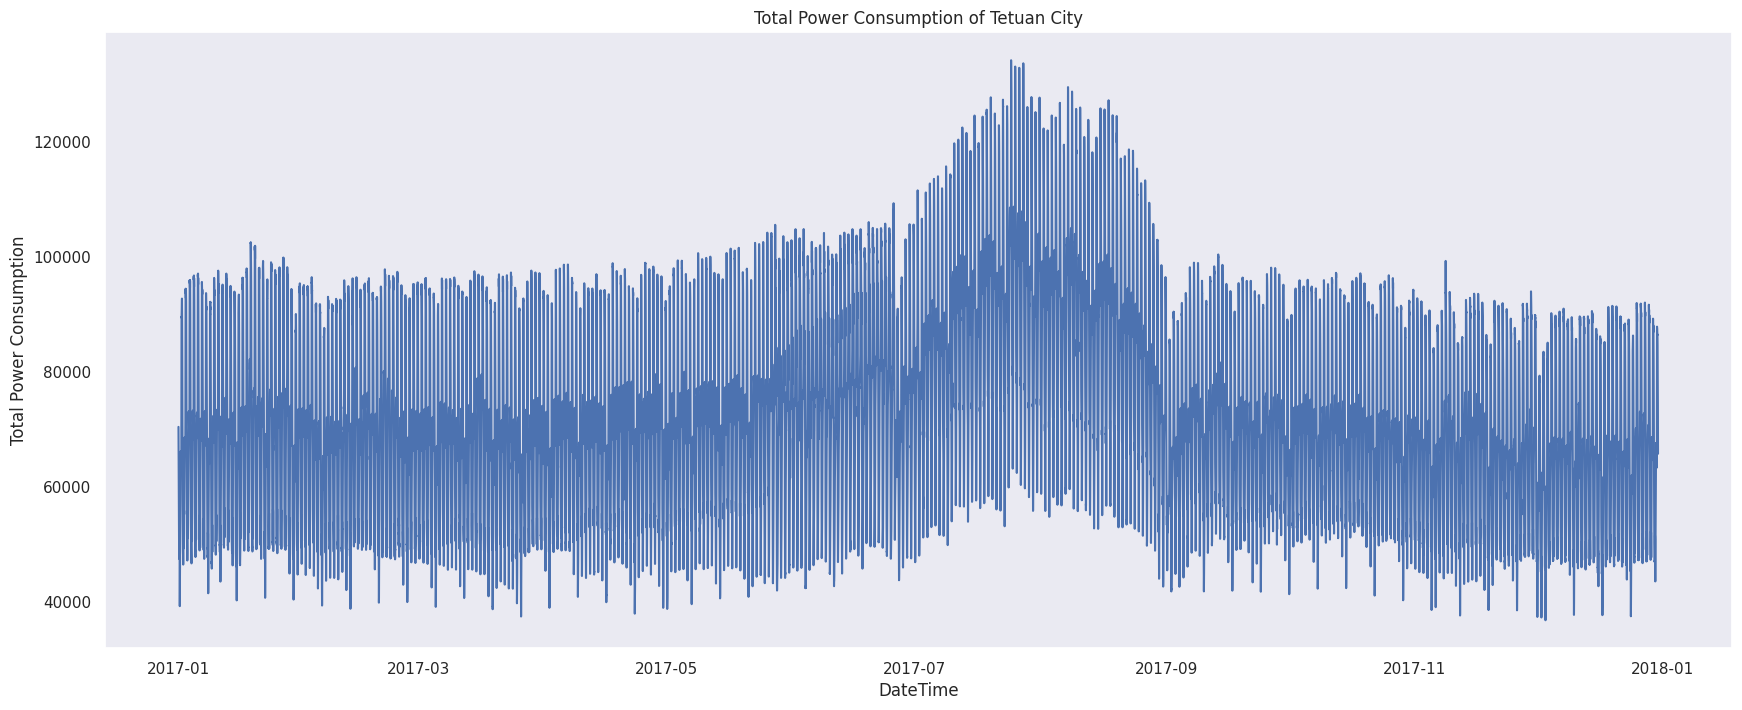

In [ ]:
plt.figure(figsize=(21, 8))
plt.plot(data['Total Power Consumption'])
plt.title('Total Power Consumption of Tetuan City')
plt.ylabel('Total Power Consumption')
plt.xlabel('DateTime')
plt.grid(False)
plt.show()

Dataset has 309 records and 2 columns


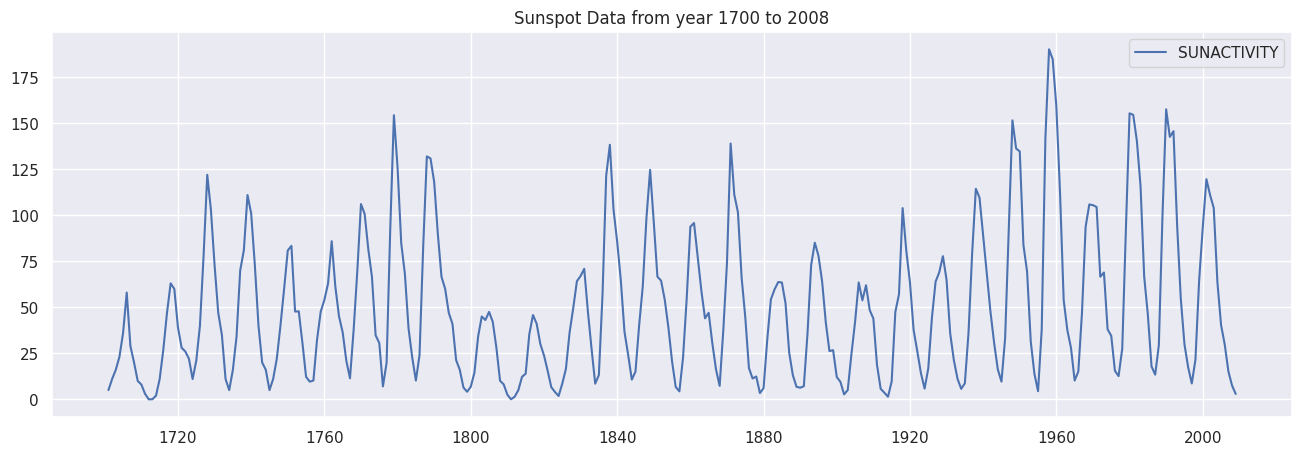

Results of Dickey-Fuller Test:
Test Statistic                  -2.837781
p-value                          0.053076
#Lags Used                       8.000000
Number of Observations Used    300.000000
Critical Value (1%)             -3.452337
Critical Value (5%)             -2.871223
Critical Value (10%)            -2.571929
dtype: float64


In [ ]:
import statsmodels.api as sm

# Load the dataset
df = sm.datasets.sunspots.load_pandas().data
# Check the dimensionality of the dataset
df.shape
print("Dataset has {} records and {} columns".format(df.shape[0], df.shape[1]))
# Changing the YEAR data type and setting it as index
df['YEAR'] = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
df.index = df['YEAR']
# Check the data type
del df['YEAR']
# View the dataset
df.head()
# Plotting the Data
# Define the plot size
plt.figure(figsize=(16,5))
# Plot the data
plt.plot(df.index, df['SUNACTIVITY'], label = "SUNACTIVITY")
plt.legend(loc='best')
plt.title("Sunspot Data from year 1700 to 2008")
plt.show()
# ADF Test
# Function to print out results in customised manner
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df['SUNACTIVITY'])

In [ ]:
adf_test(data['Total Power Consumption'])

Results of Dickey-Fuller Test:
Test Statistic                   -26.567630
p-value                            0.000000
#Lags Used                        58.000000
Number of Observations Used    52357.000000
Critical Value (1%)               -3.430475
Critical Value (5%)               -2.861595
Critical Value (10%)              -2.566799
dtype: float64


# Test Statistic is less than the critical values thus it is stationary.
# p-value is also less than the significance level (0.05) thus we can reject the null hypothesis. Thereby inferring that the series is stationary.

reference:
 - <a href="https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=When%20the%20test%20statistic%20is%20lower%20than%20the%20critical%20value%20shown%2C%20you%20reject%20the%20null%20hypothesis%20and%20infer%20that%20the%20time%20series%20is%20stationary."> When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary. </a>
 - <a href="https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=the%20p%2Dvalue%20obtained%20should%20be%20less%20than%20the%20significance%20level%20(say%200.05)%20in%20order%20to%20reject%20the%20null%20hypothesis.%20Thereby%20inferring%20that%20the%20series%20is%20stationary."> the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby inferring that the series is stationary. </a>

<h1> <a href="https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775#:~:text=Ideally%2C%20we%20want%20to%20have%20a%20stationary%20time%20series%20for%20modelling.%20Of%20course%2C%20not%20all%20of%20them%20are%20stationary%2C%20but%20we%20can%20make%20different%20transformations%20to%20make%20them%20stationary."> Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can make different transformations to make them stationary. </a> </h1>

In [ ]:
# drop Zone 1, Zone 2 and Zone 3
data.drop(['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1, inplace=True)

In [ ]:
split_date = '2017-11-01 00:00:00'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

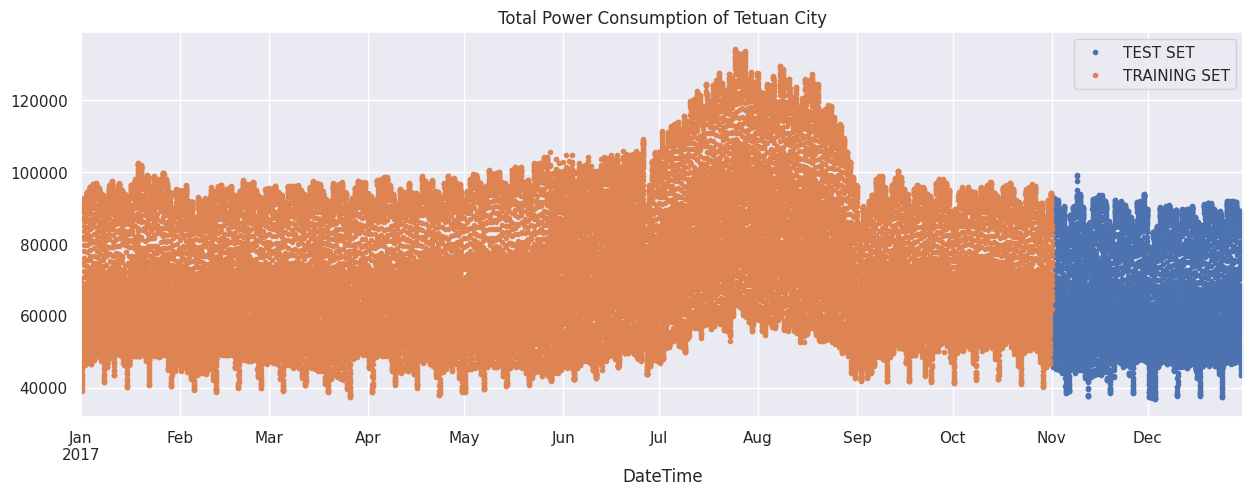

In [ ]:
_ = data_test \
    .rename(columns={'Total Power Consumption': 'TEST SET'}) \
    .join(data_train.rename(columns={'Total Power Consumption': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Total Power Consumption of Tetuan City', style='.')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','minute','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(data_train, label='Total Power Consumption')
X_test, y_test = create_features(data_test, label='Total Power Consumption')
X_test.isnull().sum()

<ipython-input-45-208613d426aa>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-45-208613d426aa>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


hour          0
minute        0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=np.nan, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

[15:09:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

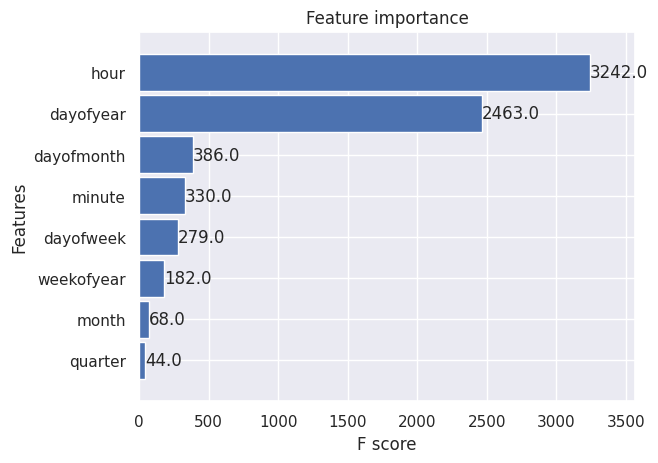

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
data_test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

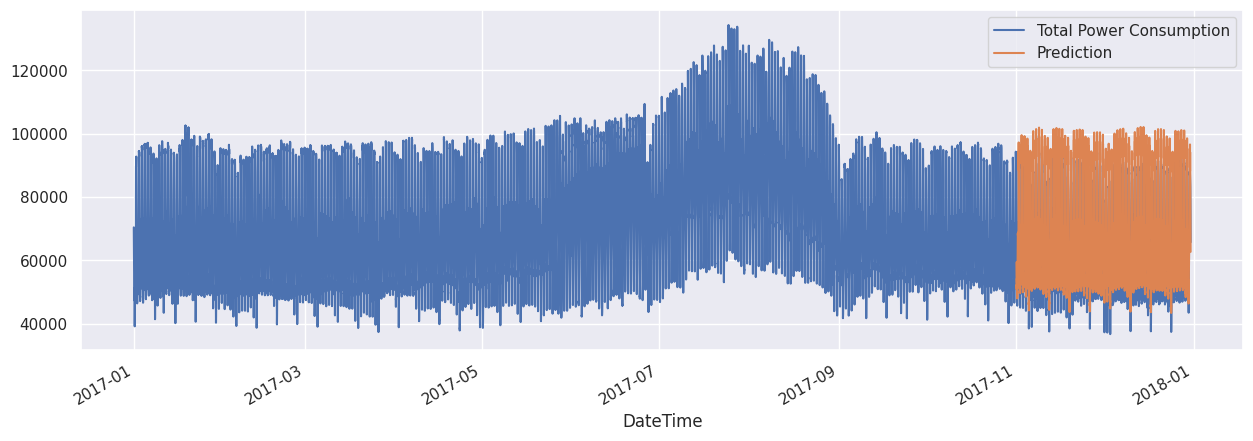

In [ ]:
_ = data_all[['Total Power Consumption','Prediction']].plot(figsize=(15, 5))

In [ ]:
data_all[['Prediction','Total Power Consumption']]

,Prediction,Total Power Consumption
DateTime,,
2017-11-01 00:10:00,59404.894531,61314.21096
2017-11-01 00:20:00,58240.480469,60426.11348
2017-11-01 00:30:00,57433.964844,59244.04276
2017-11-01 00:40:00,56812.914062,58129.05375
2017-11-01 00:50:00,56322.886719,56399.66413
...,...,...
2017-10-31 23:20:00,NaN,68505.52458
2017-10-31 23:30:00,NaN,66873.99145
2017-10-31 23:40:00,NaN,65574.82177


In [ ]:
from datetime import datetime, timedelta
def dateRange(days:int=2):
  return datetime(2017,12,30)-timedelta(days-1), datetime(2017,12,30)

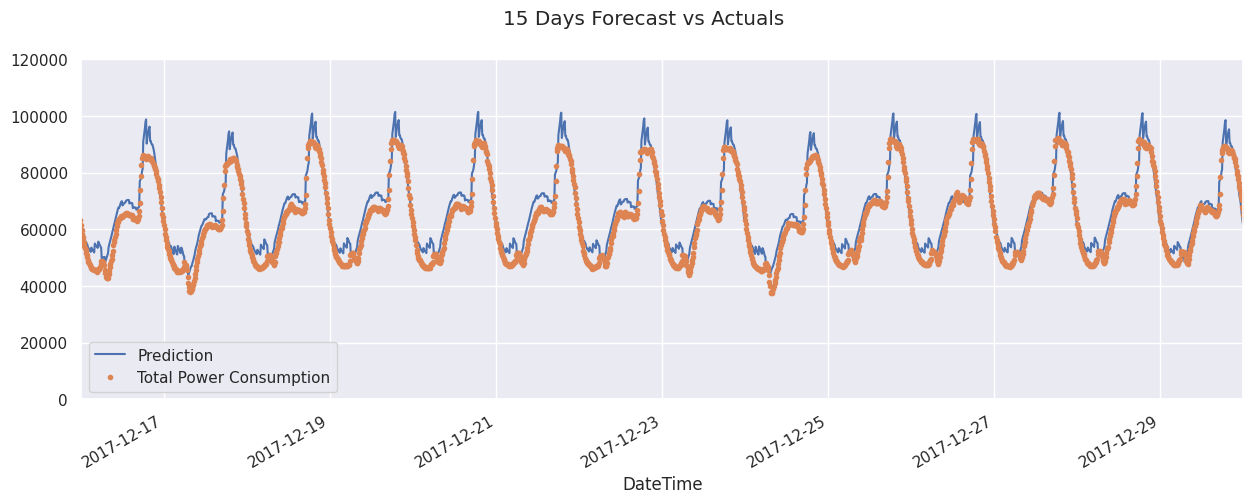

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='12-16-2017', upper='12-30-2017')
ax.set_xbound(dateRange(15))
ax.set_ylim(0, 120000)
plot = plt.suptitle('15 Days Forecast vs Actuals')

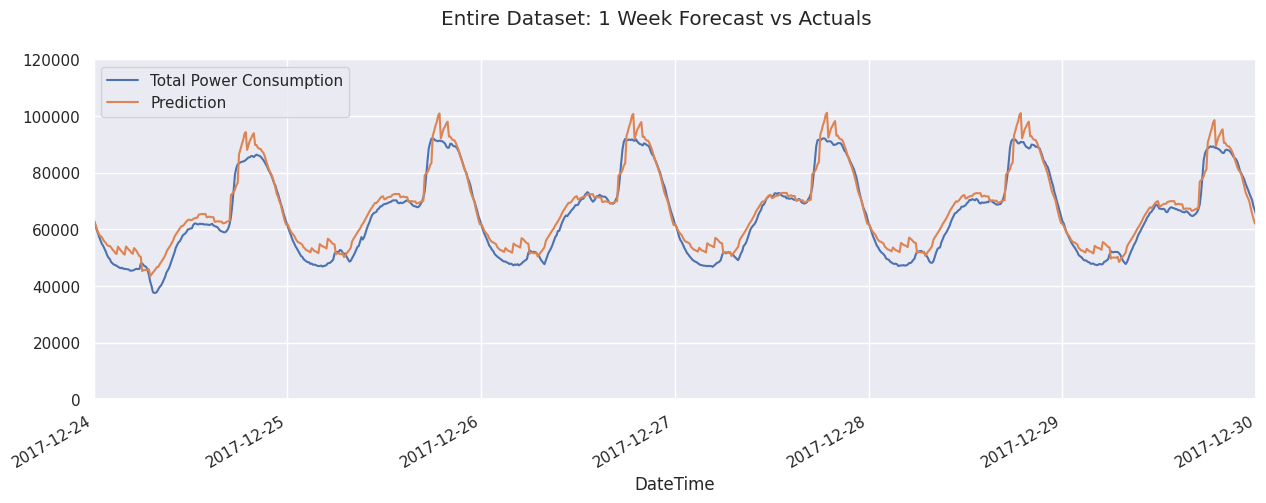

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Total Power Consumption', 'Prediction']].plot(ax=ax,
                                              style=['-','-'])
# ax.set_xbound(lower='11-01-2017', upper='11-08-2017')
ax.set_xbound(dateRange(7))
ax.set_ylim(0, 120000)
plot = plt.suptitle('Entire Dataset: 1 Week Forecast vs Actuals')

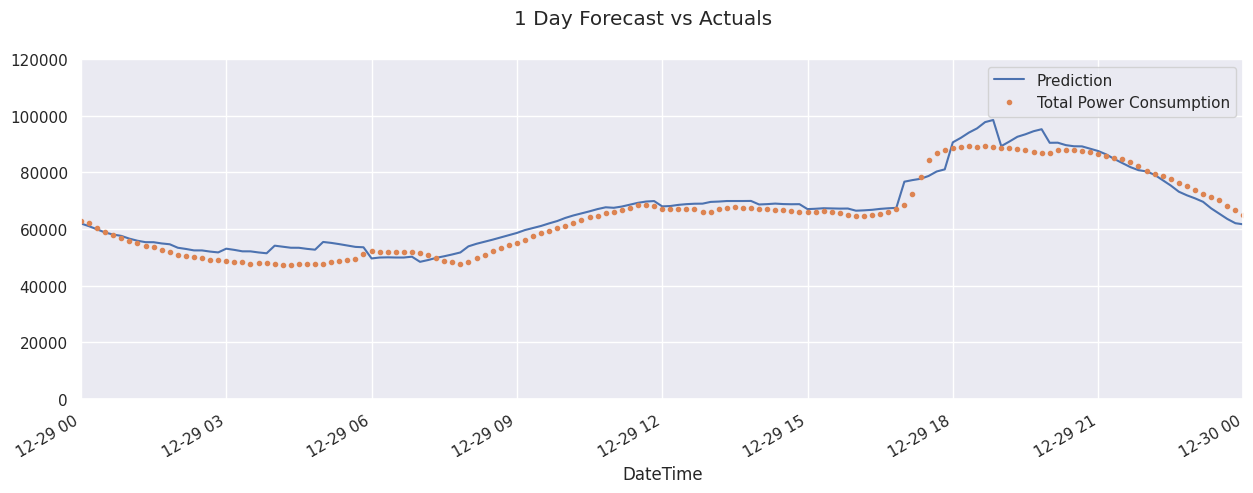

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017 00:00:00', upper='11-01-2017 23:50:00')
ax.set_xbound(dateRange())
ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Day Forecast vs Actuals')

In [ ]:
data_all

,Total Power Consumption,date,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
DateTime,,,,,,,,,,,,
2017-11-01 00:10:00,61314.21096,2017-11-01 00:10:00,0,10,2,4,11,2017,305,1,44,59404.894531
2017-11-01 00:20:00,60426.11348,2017-11-01 00:20:00,0,20,2,4,11,2017,305,1,44,58240.480469
2017-11-01 00:30:00,59244.04276,2017-11-01 00:30:00,0,30,2,4,11,2017,305,1,44,57433.964844
2017-11-01 00:40:00,58129.05375,2017-11-01 00:40:00,0,40,2,4,11,2017,305,1,44,56812.914062
2017-11-01 00:50:00,56399.66413,2017-11-01 00:50:00,0,50,2,4,11,2017,305,1,44,56322.886719
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 23:20:00,68505.52458,2017-10-31 23:20:00,23,20,1,4,10,2017,304,31,44,NaN
2017-10-31 23:30:00,66873.99145,2017-10-31 23:30:00,23,30,1,4,10,2017,304,31,44,NaN
2017-10-31 23:40:00,65574.82177,2017-10-31 23:40:00,23,40,1,4,10,2017,304,31,44,NaN


In [ ]:
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# _ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
#                                               style=['-','.'])
# ax.set_ylim(0, 120000)
# ax.set_xbound(lower='12-01-2017', upper='12-08-2017')
# plot = plt.suptitle('First Week of December Forecast vs Actuals')

In [ ]:
print('MSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MSE: 20170959.377699908


In [ ]:
print('MAE:', mean_absolute_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAE: 3686.4957124195803


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAPE:', mean_absolute_percentage_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAPE: 6.141276458540157


In [ ]:
print('MSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction'], squared=False))

MSE: 4491.2091220182465


In [ ]:
data_test['error'] = data_test['Total Power Consumption'] - data_test['Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Total Power Consumption','Prediction','error','abs_error']]

<ipython-input-63-ed8f816689ee>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_day = data_test.groupby(['year','month','dayofmonth']) \


In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Total Power Consumption    Prediction        error  \
year month dayofmonth                                                       
2017 12    1                      58574.151543  64762.027344 -6187.872871   
     11    6                      62288.536668  68277.875000 -5989.338006   
     12    2                      60104.345342  65827.328125 -5722.979474   
           3                      59192.378189  64537.035156 -5344.654661   
           13                     64306.587793  69210.390625 -4903.801123   
           16                     62336.671485  67069.953125 -4733.282508   
           12                     64338.518880  68904.492188 -4565.974799   
           14                     65028.106381  69369.265625 -4341.156260   
     11    7                      64588.154859  68880.867188 -4292.710023   
     12    7                      64821.612249  69106.515625 -4284.898276   

                         abs_error  
year month dayofmonth               
2017 12    1           6384.171803  
     11    6           6074.192907  
     12    2           5986.959278  
           3           5600.052281  
           13          5150.495580  
           16          4975.200423  
           12          4829.543965  
           14          4706.692615  
     11    7           4472.850072  
     12    7           4651.329932

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Total Power Consumption    Prediction        error  \
year month dayofmonth                                                       
2017 12    1                      58574.151543  64762.027344 -6187.872871   
     11    6                      62288.536668  68277.875000 -5989.338006   
     12    2                      60104.345342  65827.328125 -5722.979474   
           3                      59192.378189  64537.035156 -5344.654661   
           13                     64306.587793  69210.390625 -4903.801123   
           16                     62336.671485  67069.953125 -4733.282508   
           12                     64338.518880  68904.492188 -4565.974799   
           14                     65028.106381  69369.265625 -4341.156260   
           7                      64821.612249  69106.515625 -4284.898276   
     11    7                      64588.154859  68880.867188 -4292.710023   

                         abs_error  
year month dayofmonth               
2017 12    1           6384.171803  
     11    6           6074.192907  
     12    2           5986.959278  
           3           5600.052281  
           13          5150.495580  
           16          4975.200423  
           12          4829.543965  
           14          4706.692615  
           7           4651.329932  
     11    7           4472.850072

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Total Power Consumption    Prediction        error  \
year month dayofmonth                                                       
2017 11    1                      66609.966056  65890.132812   719.830840   
           2                      66021.431324  67554.109375 -1532.678485   
           10                     66362.502407  67433.710938 -1071.205221   
           4                      65428.802424  67033.968750 -1605.161307   
           30                     65452.570795  67222.625000 -1770.057569   
           17                     67452.481648  67425.398438    27.085190   
           15                     66992.747531  68643.531250 -1650.782145   
           9                      68324.222167  68594.898438  -270.670465   
     12    30                     63917.780647  65382.250000 -1464.471198   
     11    29                     66926.180006  67726.843750  -800.663988   

                         abs_error  
year month dayofmonth               
2017 11    1           1827.792747  
           2           2030.092282  
           10          2213.170552  
           4           2415.981499  
           30          2429.877543  
           17          2435.062062  
           15          2477.896487  
           9           2557.115750  
     12    30          2628.682894  
     11    29          2676.682352

# 50 Days Sample

In [ ]:
data_50 = data["2017-11-11 00:00:00":]
print(len(data_50))
train_size = int(len(data_50) * 0.7)
data_train = data_50[0:train_size]
data_test = data_50[train_size:]
print(len(data_train), len(data_test))

7200
5040 2160


In [ ]:
print('Training days: ', len(data_train)/(6*24))
print('Test days:', len(data_test)/(6*24))

Training days:  35.0
Test days: 15.0


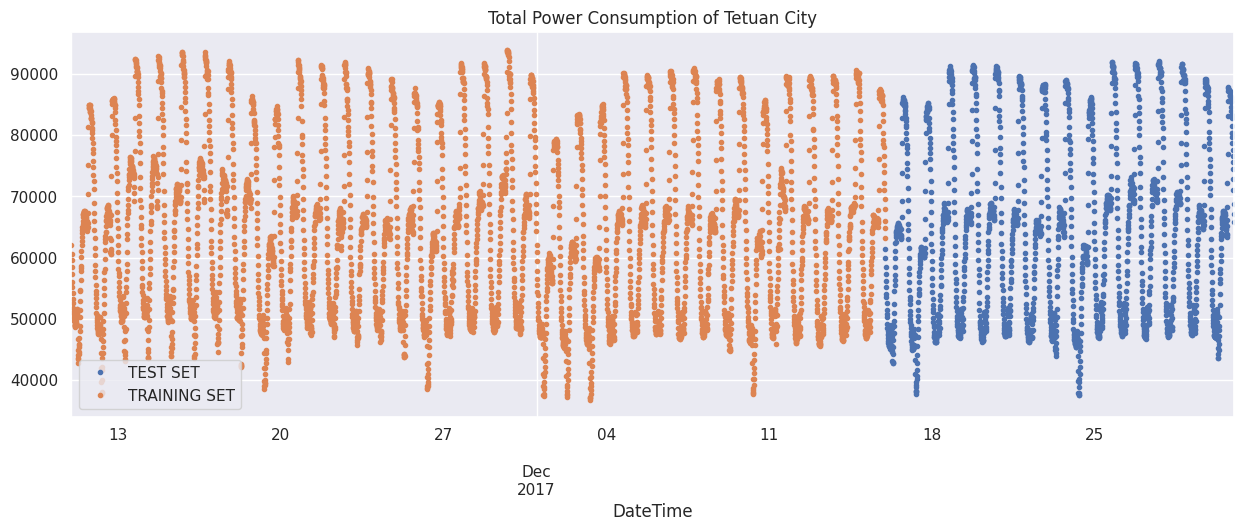

In [ ]:
_ = data_test \
    .rename(columns={'Total Power Consumption': 'TEST SET'}) \
    .join(data_train.rename(columns={'Total Power Consumption': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Total Power Consumption of Tetuan City', style='.')

In [ ]:
X_train, y_train = create_features(data_train, label='Total Power Consumption')
X_test, y_test = create_features(data_test, label='Total Power Consumption')
X_test.isnull().sum()

<ipython-input-12-208613d426aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-12-208613d426aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-12-208613d426aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

hour          0
minute        0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=np.nan, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

[14:16:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

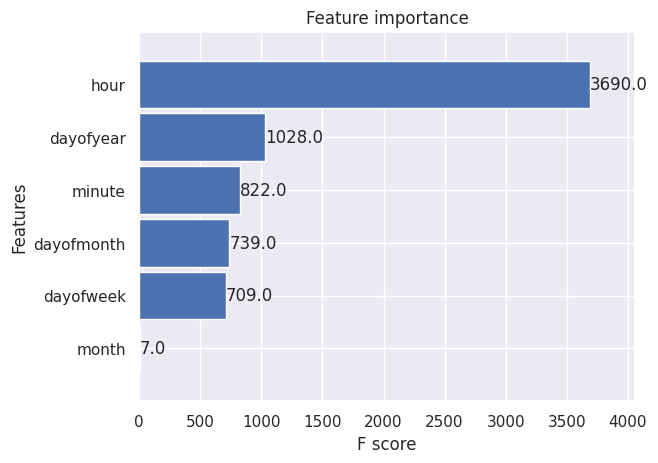

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
data_test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

<ipython-input-40-245247783416>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediction'] = reg.predict(X_test)


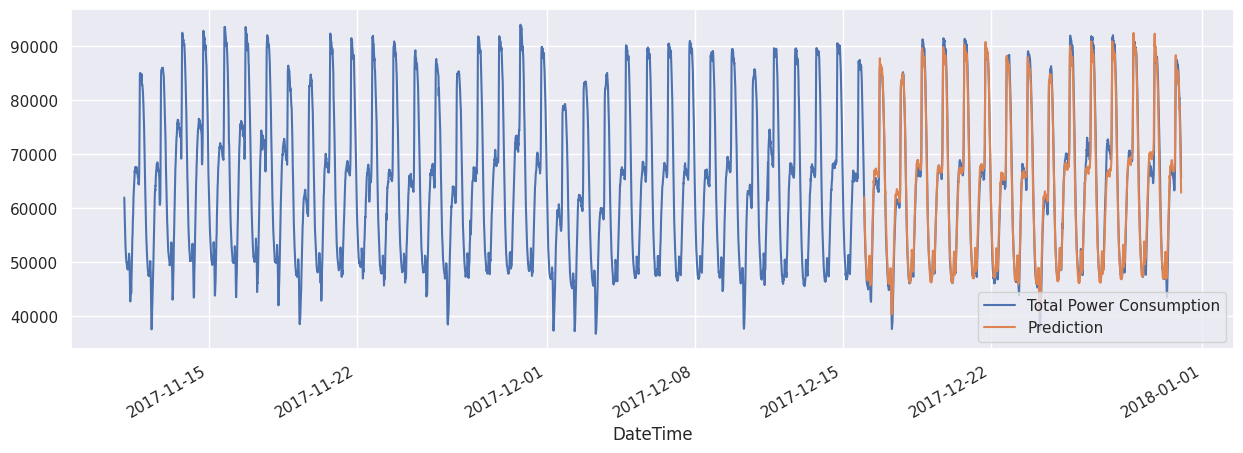

In [ ]:
_ = data_all[['Total Power Consumption','Prediction']].plot(figsize=(15, 5))

In [ ]:
data_all[['Prediction','Total Power Consumption']]

,Prediction,Total Power Consumption
DateTime,,
2017-12-16 00:00:00,62022.363281,61346.07666
2017-12-16 00:10:00,60848.785156,59841.73153
2017-12-16 00:20:00,59399.468750,58469.28636
2017-12-16 00:30:00,58196.753906,57239.78104
2017-12-16 00:40:00,57091.371094,56161.60690
...,...,...
2017-12-15 23:10:00,NaN,69521.30924
2017-12-15 23:20:00,NaN,67920.24703
2017-12-15 23:30:00,NaN,65894.02595


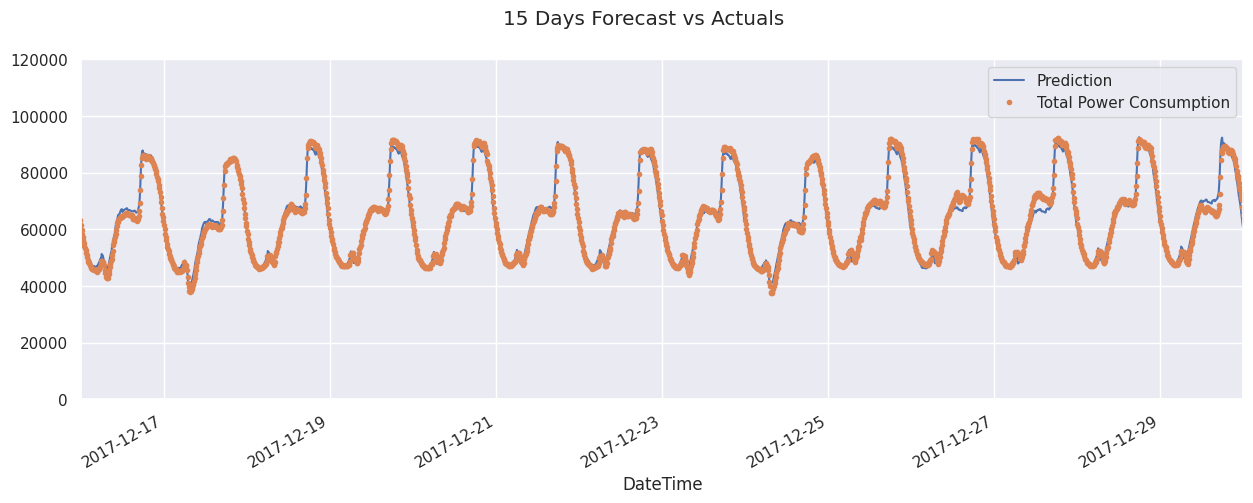

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='12-16-2017', upper='12-30-2017')
ax.set_xbound(dateRange(15))
ax.set_ylim(0, 120000)
plot = plt.suptitle('15 Days Forecast vs Actuals')

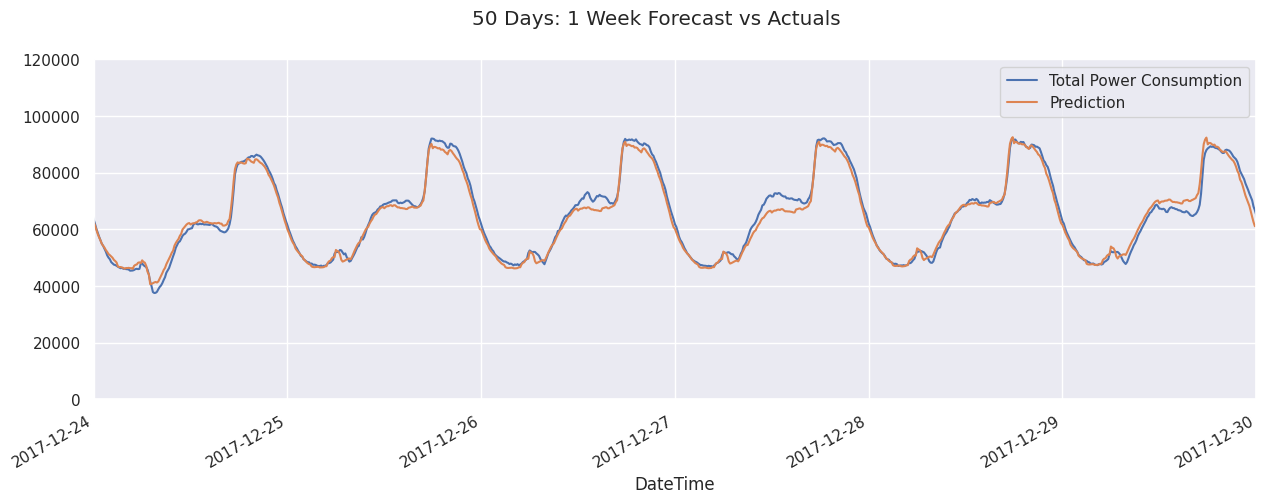

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
# _ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
#                                               style=['-','.'])
_ = data_all[['Total Power Consumption','Prediction']].plot(ax=ax,
                                              style=['-','-'])
# ax.set_xbound(lower='11-01-2017', upper='11-08-2017')
ax.set_xbound(dateRange(7))
ax.set_ylim(0, 120000)
plot = plt.suptitle('50 Days: 1 Week Forecast vs Actuals')

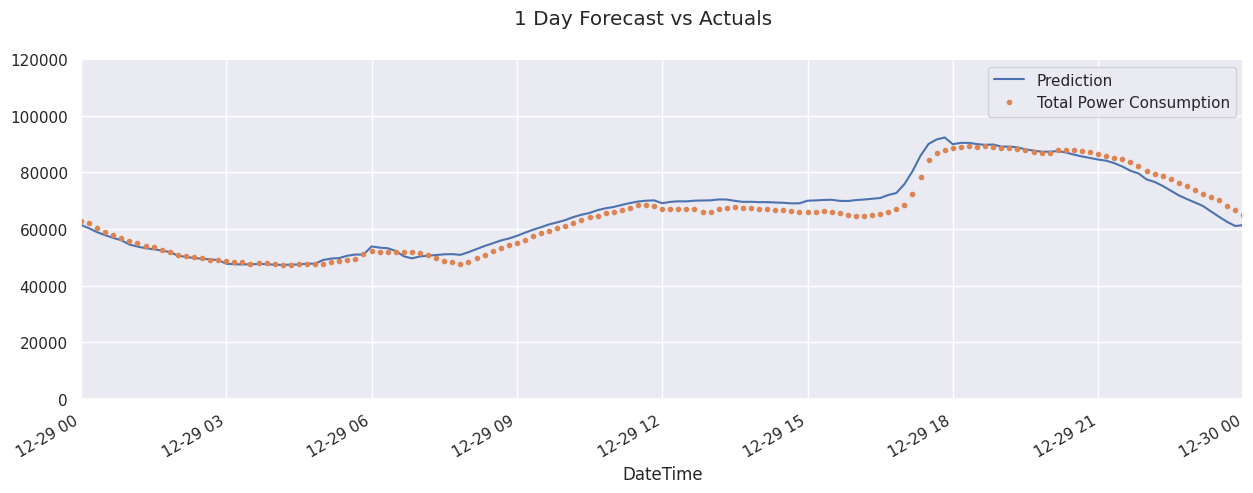

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017 00:00:00', upper='11-01-2017 23:50:00')
ax.set_xbound(dateRange())
ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Day Forecast vs Actuals')

In [ ]:
data_all

,Total Power Consumption,date,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
DateTime,,,,,,,,,,,,
2017-12-16 00:00:00,61346.07666,2017-12-16 00:00:00,0,0,5,4,12,2017,350,16,50,62022.363281
2017-12-16 00:10:00,59841.73153,2017-12-16 00:10:00,0,10,5,4,12,2017,350,16,50,60848.785156
2017-12-16 00:20:00,58469.28636,2017-12-16 00:20:00,0,20,5,4,12,2017,350,16,50,59399.468750
2017-12-16 00:30:00,57239.78104,2017-12-16 00:30:00,0,30,5,4,12,2017,350,16,50,58196.753906
2017-12-16 00:40:00,56161.60690,2017-12-16 00:40:00,0,40,5,4,12,2017,350,16,50,57091.371094
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-15 23:10:00,69521.30924,2017-12-15 23:10:00,23,10,4,4,12,2017,349,15,50,NaN
2017-12-15 23:20:00,67920.24703,2017-12-15 23:20:00,23,20,4,4,12,2017,349,15,50,NaN
2017-12-15 23:30:00,65894.02595,2017-12-15 23:30:00,23,30,4,4,12,2017,349,15,50,NaN


In [ ]:
print('MSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MSE: 3355274.3201577663


In [ ]:
print('MAE:', mean_absolute_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAE: 1442.2628483238425


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAPE:', mean_absolute_percentage_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAPE: 2.2841551825237247


In [ ]:
print('RMSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction'], squared=False))

RMSE: 1831.7407895654248


# 15 Days Sample

In [ ]:
data_15 = data["2017-12-16 00:00:00":]
print(len(data_15))
train_size = int(len(data_15) * 0.7)
data_train = data_15[0:train_size]
data_test = data_15[train_size:]
print(len(data_train), len(data_test))

2160
1512 648


In [ ]:
print('Training days: ', len(data_train)/(6*24))
print('Test days:', len(data_test)/(6*24))

Training days:  10.5
Test days: 4.5


In [ ]:
data_train

,Total Power Consumption
DateTime,
2017-12-16 00:00:00,61346.076660
2017-12-16 00:10:00,59841.731530
2017-12-16 00:20:00,58469.286360
2017-12-16 00:30:00,57239.781040
2017-12-16 00:40:00,56161.606900
...,...
2017-12-26 11:10:00,66621.400991
2017-12-26 11:20:00,67092.556926
2017-12-26 11:30:00,67690.512441


In [ ]:
data_test

,Total Power Consumption
DateTime,
2017-12-26 12:00:00,68619.355085
2017-12-26 12:10:00,69654.302581
2017-12-26 12:20:00,70247.423480
2017-12-26 12:30:00,70852.390870
2017-12-26 12:40:00,70748.015480
...,...
2017-12-30 23:10:00,72798.086590
2017-12-30 23:20:00,70983.807860
2017-12-30 23:30:00,68675.049650


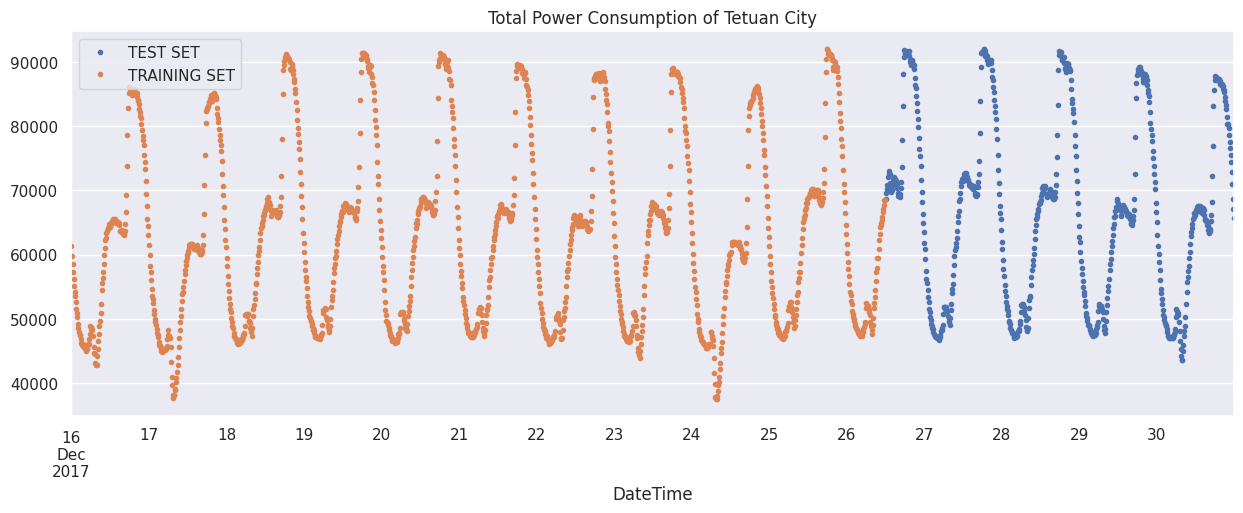

In [ ]:
_ = data_test \
    .rename(columns={'Total Power Consumption': 'TEST SET'}) \
    .join(data_train.rename(columns={'Total Power Consumption': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Total Power Consumption of Tetuan City', style='.')

In [ ]:
X_train, y_train = create_features(data_train, label='Total Power Consumption')
X_test, y_test = create_features(data_test, label='Total Power Consumption')
X_test.isnull().sum()

<ipython-input-12-208613d426aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-12-208613d426aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-12-208613d426aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

hour          0
minute        0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=np.nan, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

[14:16:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

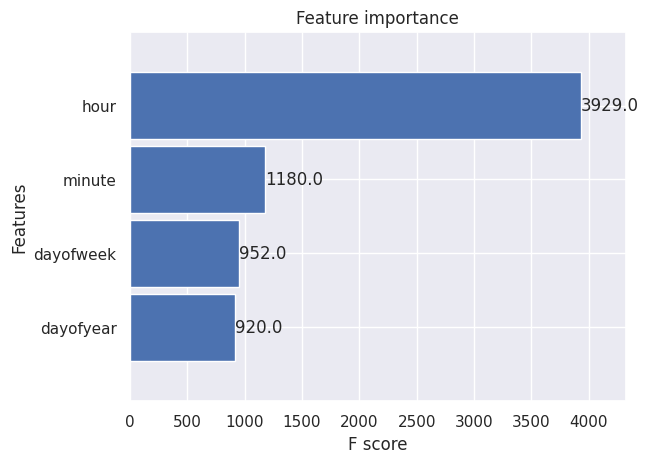

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
data_test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

<ipython-input-60-245247783416>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediction'] = reg.predict(X_test)


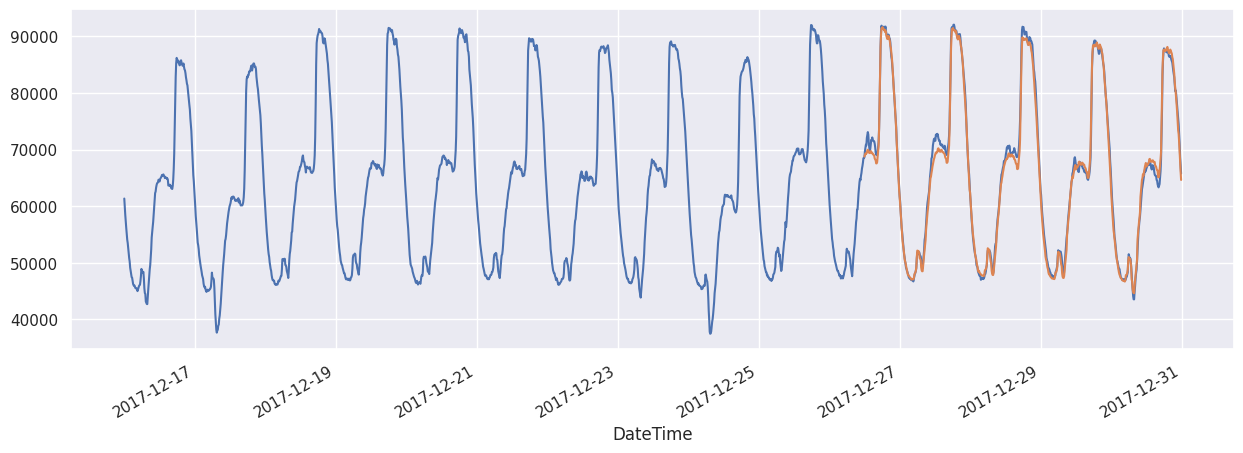

In [ ]:
_ = data_all[['Total Power Consumption','Prediction']].plot(figsize=(15, 5), legend = False)

In [ ]:
data_all[['Prediction','Total Power Consumption']]

,Prediction,Total Power Consumption
DateTime,,
2017-12-26 12:00:00,68759.773438,68619.355085
2017-12-26 12:10:00,69003.289062,69654.302581
2017-12-26 12:20:00,69291.875000,70247.423480
2017-12-26 12:30:00,69182.773438,70852.390870
2017-12-26 12:40:00,69334.007812,70748.015480
...,...,...
2017-12-26 11:10:00,NaN,66621.400991
2017-12-26 11:20:00,NaN,67092.556926
2017-12-26 11:30:00,NaN,67690.512441


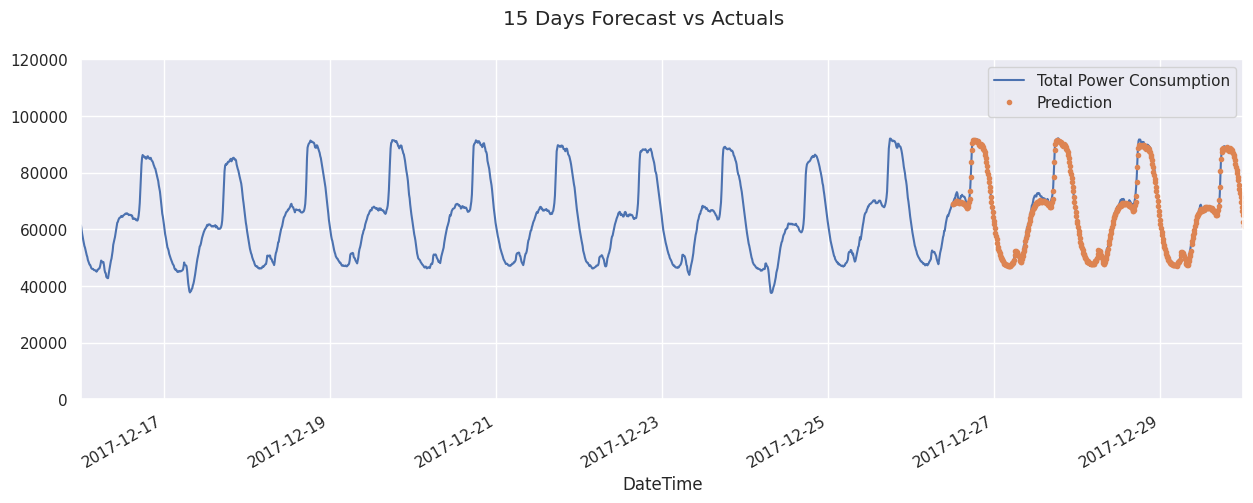

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Total Power Consumption', 'Prediction']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='12-16-2017', upper='12-30-2017')
ax.set_xbound(dateRange(15))
ax.set_ylim(0, 120000)
plot = plt.suptitle('15 Days Forecast vs Actuals')

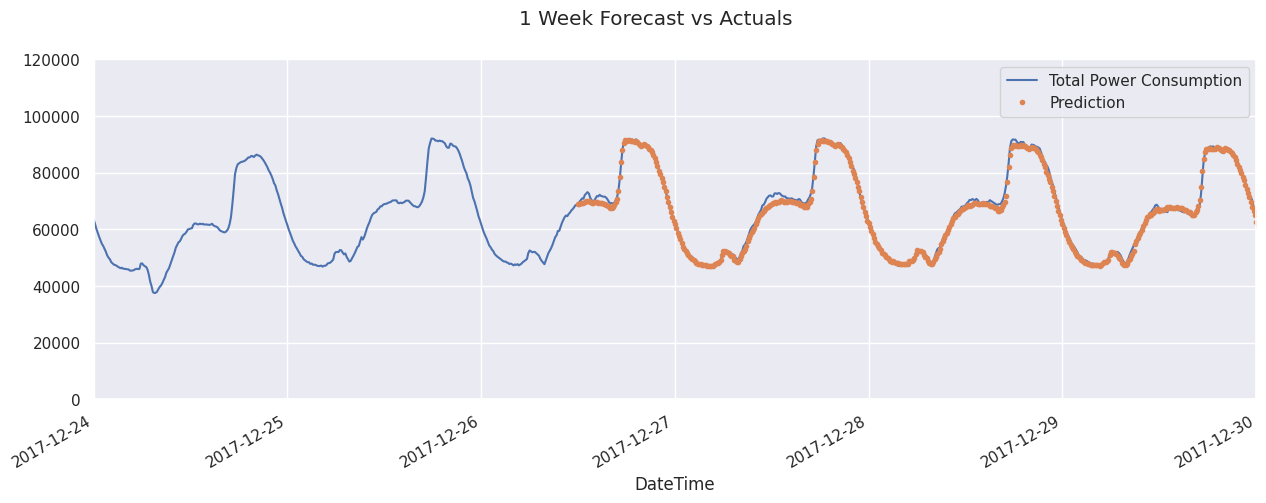

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Total Power Consumption', 'Prediction']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017', upper='11-08-2017')
ax.set_xbound(dateRange(7))
ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Week Forecast vs Actuals')

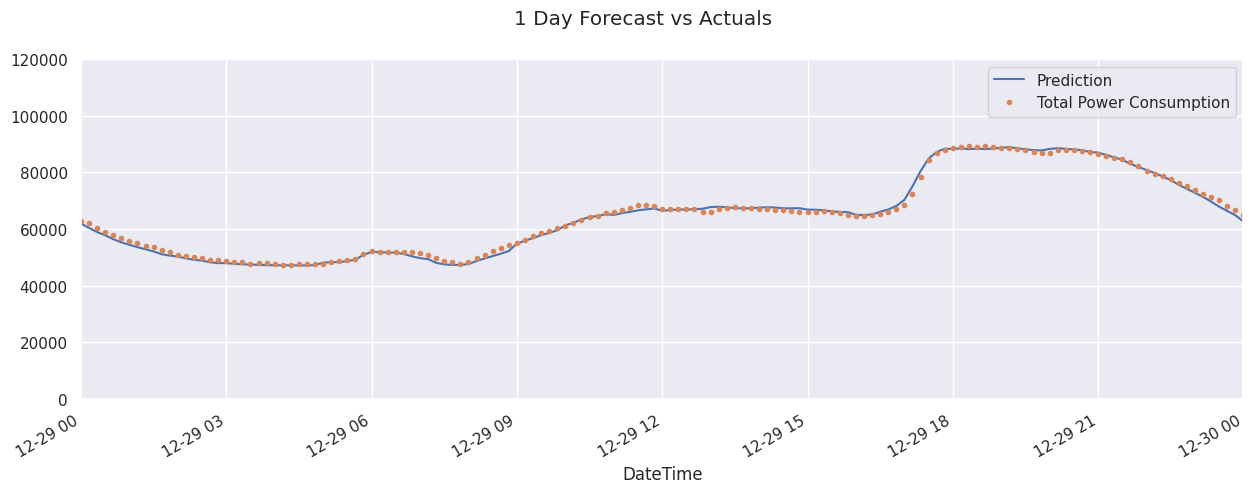

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017 00:00:00', upper='11-01-2017 23:50:00')
ax.set_xbound(dateRange())
ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Day Forecast vs Actuals')

In [ ]:
data_all

,Total Power Consumption,date,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
DateTime,,,,,,,,,,,,
2017-12-26 12:00:00,68619.355085,2017-12-26 12:00:00,12,0,1,4,12,2017,360,26,52,68759.773438
2017-12-26 12:10:00,69654.302581,2017-12-26 12:10:00,12,10,1,4,12,2017,360,26,52,69003.289062
2017-12-26 12:20:00,70247.423480,2017-12-26 12:20:00,12,20,1,4,12,2017,360,26,52,69291.875000
2017-12-26 12:30:00,70852.390870,2017-12-26 12:30:00,12,30,1,4,12,2017,360,26,52,69182.773438
2017-12-26 12:40:00,70748.015480,2017-12-26 12:40:00,12,40,1,4,12,2017,360,26,52,69334.007812
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26 11:10:00,66621.400991,2017-12-26 11:10:00,11,10,1,4,12,2017,360,26,52,NaN
2017-12-26 11:20:00,67092.556926,2017-12-26 11:20:00,11,20,1,4,12,2017,360,26,52,NaN
2017-12-26 11:30:00,67690.512441,2017-12-26 11:30:00,11,30,1,4,12,2017,360,26,52,NaN


In [ ]:
print('MSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MSE: 1354095.8343581902


In [ ]:
print('MAE:', mean_absolute_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAE: 902.6767254020066


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAPE:', mean_absolute_percentage_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAPE: 1.360476147160198


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

print("MAPE:", mape(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAPE: 0.013604761471601981


In [ ]:
print("RMSE:", mean_squared_error(y_true=data_test['Total Power Consumption'],
                    y_pred=data_test['Prediction'], squared=False))

RMSE: 1163.6562354742873


# Resampled to Days

In [ ]:
daily_data = data.resample('D').sum()
daily_data

,Total Power Consumption
DateTime,
2017-01-01,9.226342e+06
2017-01-02,9.539709e+06
2017-01-03,9.826635e+06
2017-01-04,9.859047e+06
2017-01-05,9.864148e+06
...,...
2017-12-26,9.527927e+06
2017-12-27,9.579272e+06
2017-12-28,9.506777e+06


In [ ]:
train_size = int(len(daily_data) * 0.7)
data_train = daily_data[0:train_size]
data_test = daily_data[train_size:]
print(len(data_train), len(data_test))

254 110


In [ ]:
print('Training days: ', len(data_train))
print('Test days:', len(data_test))

Training days:  254
Test days: 110


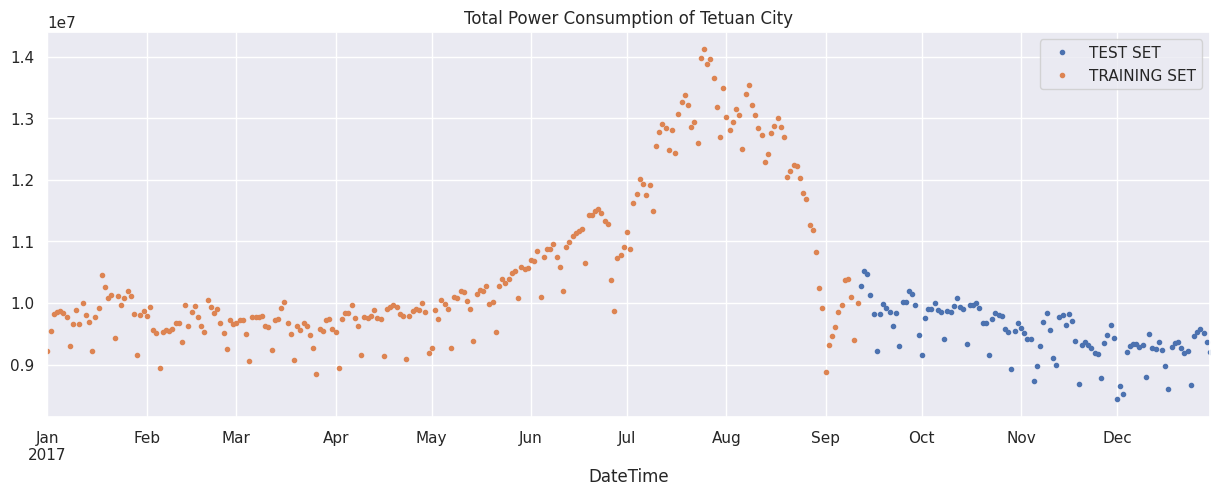

In [ ]:
_ = data_test \
    .rename(columns={'Total Power Consumption': 'TEST SET'}) \
    .join(data_train.rename(columns={'Total Power Consumption': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Total Power Consumption of Tetuan City', style='.')

In [ ]:
X_train, y_train = create_features(data_train, label='Total Power Consumption')
X_test, y_test = create_features(data_test, label='Total Power Consumption')
X_test.isnull().sum()

<ipython-input-12-208613d426aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-12-208613d426aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-12-208613d426aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

hour          0
minute        0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=np.nan, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

[14:16:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

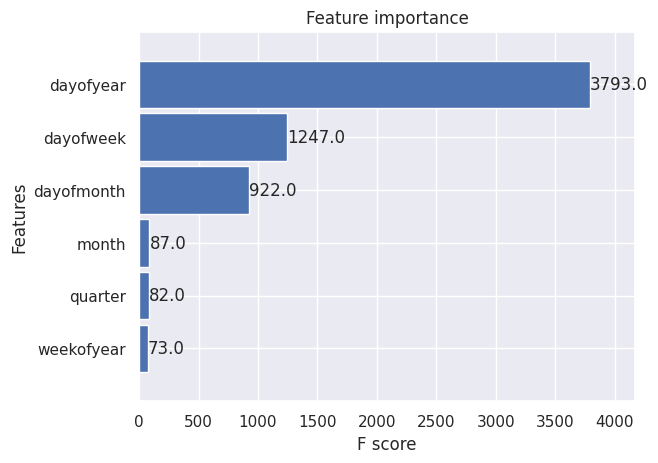

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
data_test['Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

<ipython-input-80-245247783416>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediction'] = reg.predict(X_test)


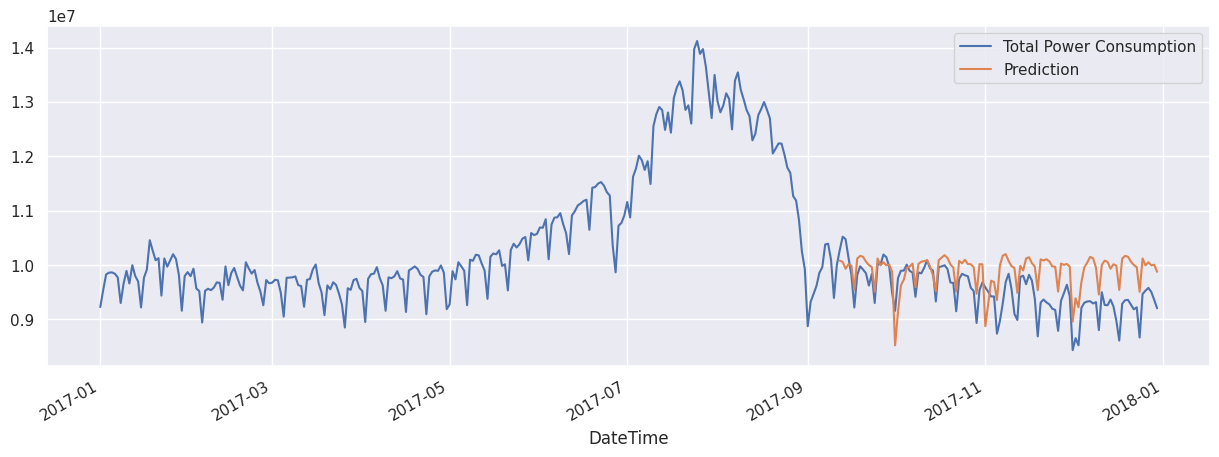

In [ ]:
_ = data_all[['Total Power Consumption','Prediction']].plot(figsize=(15, 5))

In [ ]:
data_all[['Prediction','Total Power Consumption']]

,Prediction,Total Power Consumption
DateTime,,
2017-09-12,10080632.0,1.027560e+07
2017-09-13,10056821.0,1.052096e+07
2017-09-14,9930568.0,1.047547e+07
2017-09-15,10013597.0,1.013224e+07
2017-09-16,9987734.0,9.816077e+06
...,...,...
2017-09-07,NaN,1.037797e+07
2017-09-08,NaN,1.039164e+07
2017-09-09,NaN,1.009403e+07


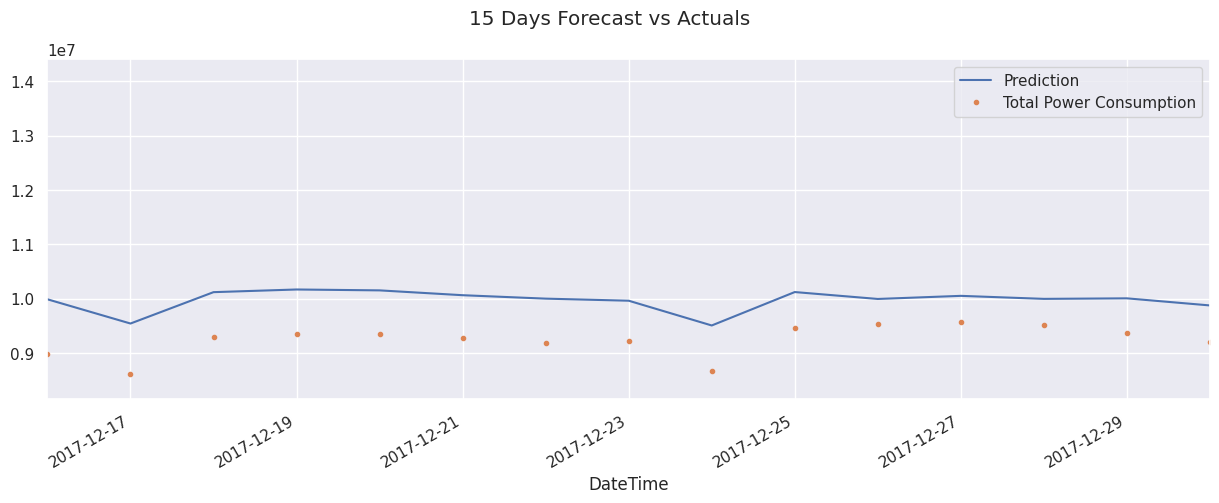

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='12-16-2017', upper='12-30-2017')
ax.set_xbound(dateRange(15))
# ax.set_ylim(0, 120000)
plot = plt.suptitle('15 Days Forecast vs Actuals')

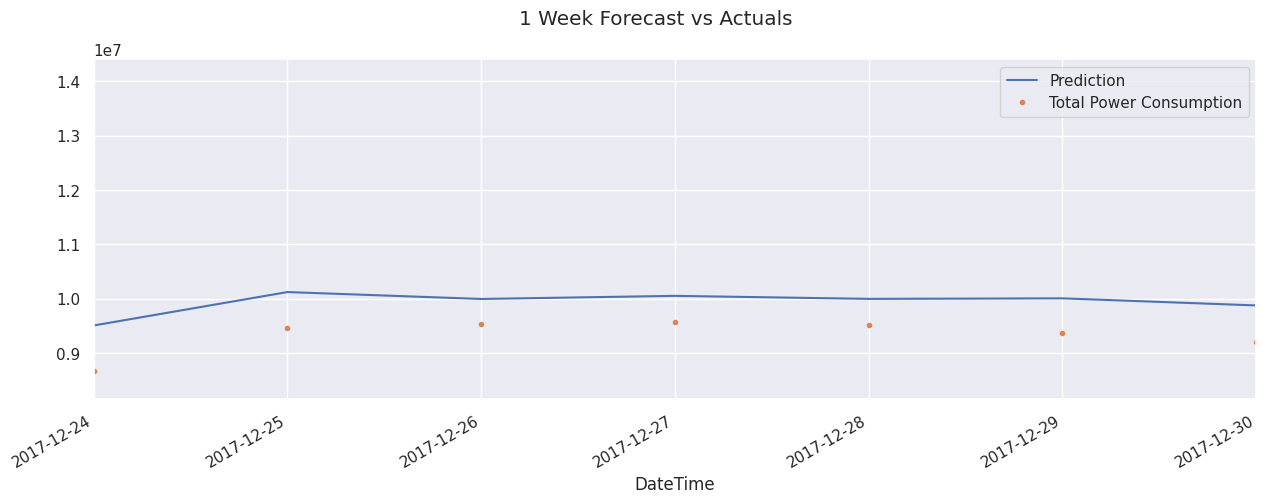

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017', upper='11-08-2017')
ax.set_xbound(dateRange(7))
# ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Week Forecast vs Actuals')

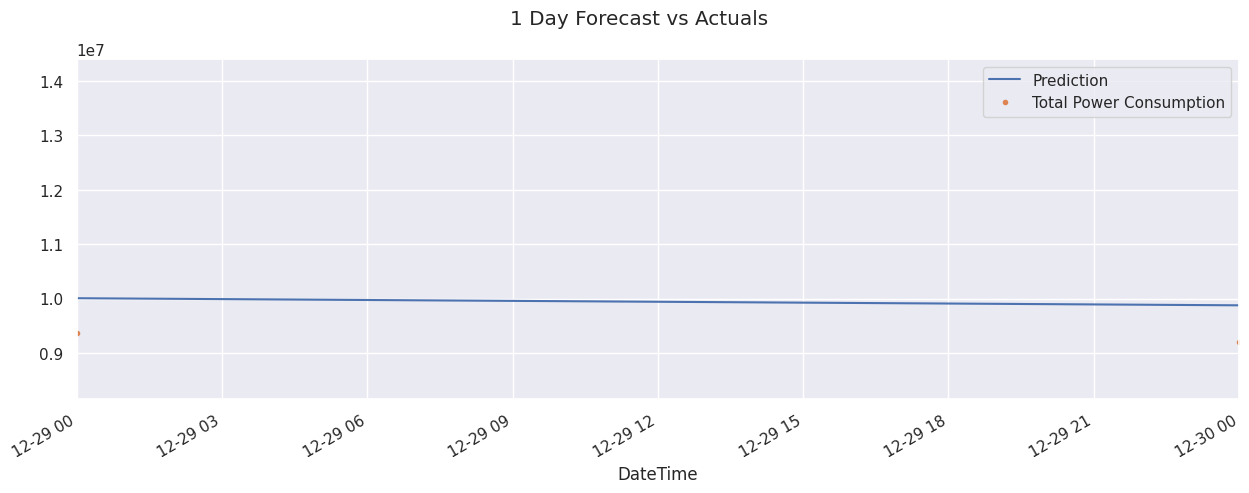

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Prediction','Total Power Consumption']].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='11-01-2017 00:00:00', upper='11-01-2017 23:50:00')
ax.set_xbound(dateRange())
# ax.set_ylim(0, 120000)
plot = plt.suptitle('1 Day Forecast vs Actuals')

In [ ]:
data_all

,Total Power Consumption,date,hour,minute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
DateTime,,,,,,,,,,,,
2017-09-12,1.027560e+07,2017-09-12,0,0,1,3,9,2017,255,12,37,10080632.0
2017-09-13,1.052096e+07,2017-09-13,0,0,2,3,9,2017,256,13,37,10056821.0
2017-09-14,1.047547e+07,2017-09-14,0,0,3,3,9,2017,257,14,37,9930568.0
2017-09-15,1.013224e+07,2017-09-15,0,0,4,3,9,2017,258,15,37,10013597.0
2017-09-16,9.816077e+06,2017-09-16,0,0,5,3,9,2017,259,16,37,9987734.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-07,1.037797e+07,2017-09-07,0,0,3,3,9,2017,250,7,36,NaN
2017-09-08,1.039164e+07,2017-09-08,0,0,4,3,9,2017,251,8,36,NaN
2017-09-09,1.009403e+07,2017-09-09,0,0,5,3,9,2017,252,9,36,NaN


In [ ]:
print('MSE:', mean_squared_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MSE: 281135181757.8432


In [ ]:
print('MAE:', mean_absolute_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAE: 456841.26464411814


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAPE:', mean_absolute_percentage_error(y_true=data_test['Total Power Consumption'],
                   y_pred=data_test['Prediction']))

MAPE: 4.900755914602226
